Versione 7 di LSTM --> in questa versione unisco sia il train_test_split che la k-fold cross validation.

## LOAD THE DATA


In [1]:
import os

os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'  

Creo un DataFrame pandas dal dataset CSE IDS-2018:

In [42]:
import pandas as pd

# Apro i file CSV e creo un DataFrame
#file_1 = pd.read_csv('Friday-02-03-2018_TrafficForML_CICFlowMeter.csv')
df = pd.read_csv('Friday-16-02-2018_TrafficForML_CICFlowMeter.csv', low_memory=False)

# Concateno i due file verticalmente
#df = pd.concat([file_1, file_2], axis=0, ignore_index=True)

## HANDLING TARGET FEATURE 

In [43]:
# Analizzo la colonna dei target
df["Label"].unique()

array(['Benign', 'DoS attacks-SlowHTTPTest', 'DoS attacks-Hulk', 'Label'],
      dtype=object)

In [44]:
df["Label"].value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Label                            1
Name: count, dtype: int64

Nei target è presente un'istanza con valore "Label" (non definito), la droppo:

In [45]:
# Scarto le istanze 'Label' della feature Label
df.drop(df.loc[df["Label"] == "Label"].index, inplace=True)

# Verifico
df["Label"].value_counts()

Label
DoS attacks-Hulk            461912
Benign                      446772
DoS attacks-SlowHTTPTest    139890
Name: count, dtype: int64

Per semplificare il modello e trasformarlo in una classificazione binaria, converto la feature Label (colonna dei target) facendo sì che valga 0 se l'attacco è benigno e 1 se è maligno (qualsiasi esso sia)

In [46]:
# Sostituisco i valori nella colonna 'Label' con valori numerici
df['Label'] = df['Label'].replace({'Benign': 0, 'DoS attacks-Hulk': 1, 'Bot': 1, 'DoS attacks-SlowHTTPTest': 1})


# Verifico
df["Label"].value_counts()

Label
1    601802
0    446772
Name: count, dtype: int64

In [47]:
# Per comodità rinomino la colonna dei target
y = df['Label']

## TIMESTAMP FEATURE

Osservo la colonna Timestamp per capire ogni quanto sono state fatte le osservazioni sul traffico di rete:

In [48]:
# Converto la colonna Timestamp in datetime
df['Timestamp'] = pd.to_datetime(df['Timestamp'], dayfirst=True)

# Trovo il timestamp minimo e massimo
min_timestamp = df['Timestamp'].min()
max_timestamp = df['Timestamp'].max()

# Calcolo la durata totale
duration = max_timestamp - min_timestamp

print(f"Il periodo totale di osservazione è: {duration}")

Il periodo totale di osservazione è: 0 days 11:57:52


## FEATURE SELECTION

Stampo tutte le feature del dataset per avere un'idea generale.

In [49]:
df.columns

Index(['Dst Port', 'Protocol', 'Timestamp', 'Flow Duration', 'Tot Fwd Pkts',
       'Tot Bwd Pkts', 'TotLen Fwd Pkts', 'TotLen Bwd Pkts', 'Fwd Pkt Len Max',
       'Fwd Pkt Len Min', 'Fwd Pkt Len Mean', 'Fwd Pkt Len Std',
       'Bwd Pkt Len Max', 'Bwd Pkt Len Min', 'Bwd Pkt Len Mean',
       'Bwd Pkt Len Std', 'Flow Byts/s', 'Flow Pkts/s', 'Flow IAT Mean',
       'Flow IAT Std', 'Flow IAT Max', 'Flow IAT Min', 'Fwd IAT Tot',
       'Fwd IAT Mean', 'Fwd IAT Std', 'Fwd IAT Max', 'Fwd IAT Min',
       'Bwd IAT Tot', 'Bwd IAT Mean', 'Bwd IAT Std', 'Bwd IAT Max',
       'Bwd IAT Min', 'Fwd PSH Flags', 'Bwd PSH Flags', 'Fwd URG Flags',
       'Bwd URG Flags', 'Fwd Header Len', 'Bwd Header Len', 'Fwd Pkts/s',
       'Bwd Pkts/s', 'Pkt Len Min', 'Pkt Len Max', 'Pkt Len Mean',
       'Pkt Len Std', 'Pkt Len Var', 'FIN Flag Cnt', 'SYN Flag Cnt',
       'RST Flag Cnt', 'PSH Flag Cnt', 'ACK Flag Cnt', 'URG Flag Cnt',
       'CWE Flag Count', 'ECE Flag Cnt', 'Down/Up Ratio', 'Pkt Size Avg',
      

Mediante eliminazione ricorsiva delle feature, utilizzando una random forest come classificatore, si ottiene questo sottoinsieme di 20 feature più significative:

In [50]:
selected_features = [
'Fwd Seg Size Min', 
'Init Fwd Win Byts', 
'Pkt Size Avg', 
'Pkt Len Mean', 
'Bwd Pkts/s', 
'Fwd Pkts/s', 
'Fwd Header Len', 
'Fwd IAT Min', 
'Fwd IAT Max', 
'Fwd IAT Mean', 
'Fwd IAT Tot',
'Flow IAT Min', 
'Flow IAT Max', 
'Flow IAT Mean', 
'Flow Pkts/s', 
'Bwd Header Len', 
'Flow Byts/s', 
'TotLen Fwd Pkts',
'Flow Duration']

In [51]:
# Creo un nuovo DataFrame df che contiene solo le colonne specificate (allo stesso tempo quindi droppo la feature dei target)
df = df[selected_features]

## CREATE TEST SET AND VAL SET

Suddivido il DataFrame in training set (60%), test set (20%) e validation set(20%).

In [52]:
from sklearn.model_selection import train_test_split

# Prima suddivisione: dividere il dataset in training set e test set
X_train, X_test, y_train, y_test = train_test_split(df, y, test_size=0.2, random_state=42)

# Seconda suddivisione: dividere il training set rimanente in training set e validation set
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.25, random_state=42)

# Verifico la shape
print(X_train.shape, y_train.shape)
print(X_val.shape, y_val.shape)
print(X_test.shape, y_test.shape)

(629144, 19) (629144,)
(209715, 19) (209715,)
(209715, 19) (209715,)


## TAKE A QUICK LOOK AT THE DATA STRUCTURE

Sbircio la struttura e le prime istanze del df per capire come procedere:

In [53]:
df.head()

,Fwd Seg Size Min,Init Fwd Win Byts,Pkt Size Avg,Pkt Len Mean,Bwd Pkts/s,Fwd Pkts/s,Fwd Header Len,Fwd IAT Min,Fwd IAT Max,Fwd IAT Mean,Fwd IAT Tot,Flow IAT Min,Flow IAT Max,Flow IAT Mean,Flow Pkts/s,Bwd Header Len,Flow Byts/s,TotLen Fwd Pkts,Flow Duration
0,0,-1,0,0,0,0.026633341,0,56300000,56300000,56300000,113000000,56300000,56300000,56300000,0.026633341,0,0,0,112640768
1,0,-1,0,0,0,0.026633104,0,56300000,56300000,56300000,113000000,56300000,56300000,56300000,0.026633104,0,0,0,112641773
2,20,263,57.07462687,56.23529412,2.116998521,1.106612863,460,66,9144734,940484.2727,20700000,66,9058214,314911.2576,3.223611385,880,180.9071464,2416,20784143
3,0,-1,0,0,0,0.026633325,0,56300000,56300000,56300000,113000000,56300000,56300000,56300000,0.026633325,0,0,0,112640836
4,20,58856,0,0,50000,50000,20,0,0,0,0,20,20,20,100000,20,0,0,20


In [54]:
df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 1048574 entries, 0 to 1048574
Data columns (total 19 columns):
 #   Column             Non-Null Count    Dtype 
---  ------             --------------    ----- 
 0   Fwd Seg Size Min   1048574 non-null  object
 1   Init Fwd Win Byts  1048574 non-null  object
 2   Pkt Size Avg       1048574 non-null  object
 3   Pkt Len Mean       1048574 non-null  object
 4   Bwd Pkts/s         1048574 non-null  object
 5   Fwd Pkts/s         1048574 non-null  object
 6   Fwd Header Len     1048574 non-null  object
 7   Fwd IAT Min        1048574 non-null  object
 8   Fwd IAT Max        1048574 non-null  object
 9   Fwd IAT Mean       1048574 non-null  object
 10  Fwd IAT Tot        1048574 non-null  object
 11  Flow IAT Min       1048574 non-null  object
 12  Flow IAT Max       1048574 non-null  object
 13  Flow IAT Mean      1048574 non-null  object
 14  Flow Pkts/s        1048574 non-null  object
 15  Bwd Header Len     1048574 non-null  object
 16  Flow 

## CLEAN THE DATA - Dropping inf and missing values

In [55]:
import warnings
import numpy as np
import matplotlib.pyplot as plt

Gestisco eventuali valori Nan o mancanti, che causerebbero problemi nell'addestramento della rete.

In [56]:
# Verifico se ci sono valori NaN nel df
nan_values = X_train.isna().any()

# Numero totale di valori NaN nel df
total_nan = X_train.isna().sum().sum()

# Voglio che l'output non sia troncato
pd.set_option('display.max_rows', None)
pd.set_option('display.max_columns', None)

# Me lo stampo per vedere quali feature sono mancanti (True se è mancante)
print("Numero totale di valori NaN nel DataFrame:", total_nan)
print(nan_values)

Numero totale di valori NaN nel DataFrame: 0
Fwd Seg Size Min     False
Init Fwd Win Byts    False
Pkt Size Avg         False
Pkt Len Mean         False
Bwd Pkts/s           False
Fwd Pkts/s           False
Fwd Header Len       False
Fwd IAT Min          False
Fwd IAT Max          False
Fwd IAT Mean         False
Fwd IAT Tot          False
Flow IAT Min         False
Flow IAT Max         False
Flow IAT Mean        False
Flow Pkts/s          False
Bwd Header Len       False
Flow Byts/s          False
TotLen Fwd Pkts      False
Flow Duration        False
dtype: bool


In [57]:
# Verifico quali feature contengono inf values
features_with_inf = X_train.columns[X_train.isin([np.inf]).any()]

# Stampo le feature che contengono inf values
print("Feature con inf values:")
print(features_with_inf)

Feature con inf values:
Index([], dtype='object')


In [58]:
# Setto il tipo delle numeriche a float (in modo che siano uniformi)
X_train = X_train.astype(float)

## FEATURE SCALING

Applico _MinMaxScaler_ per normalizzare le feature del dataframe, scalando i valori di ciascuna colonna nell'intervallo compreso tra 0 e 1. La normalizzazione consente di ridurre l'influenza di scale diverse tra le variabili, migliorando le prestazioni degli algoritmi di machine learning e garantendo una convergenza più rapida durante l'addestramento.

In [59]:
from sklearn.preprocessing import MinMaxScaler

Osservo le feature prima della standardizzazione:

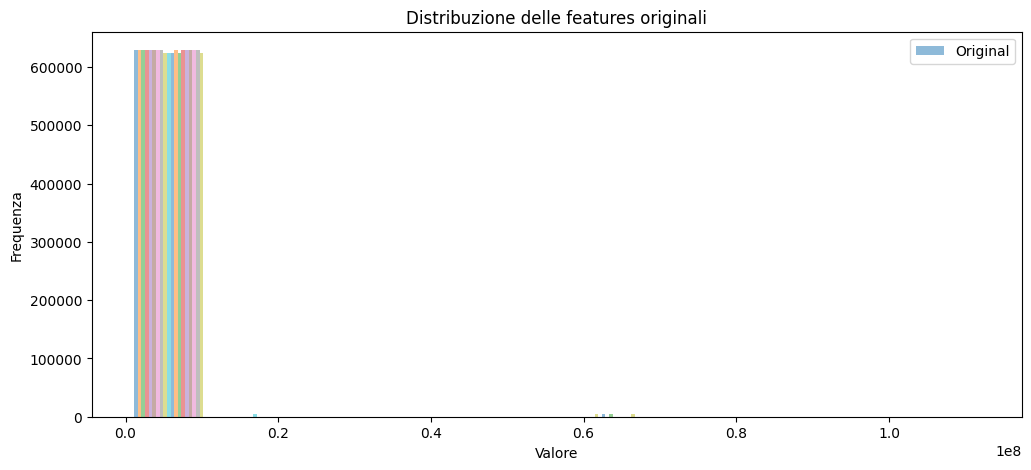

In [60]:
# Grafico dell'istogramma delle features originali
plt.figure(figsize=(12, 5))
plt.hist(X_train, bins=10, alpha=0.5, label='Original')
plt.title('Distribuzione delle features originali')
plt.xlabel('Valore')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

Ora applico la standardizzazione:

In [61]:
min_max_scaler = MinMaxScaler()
X_train = min_max_scaler.fit_transform(X_train)

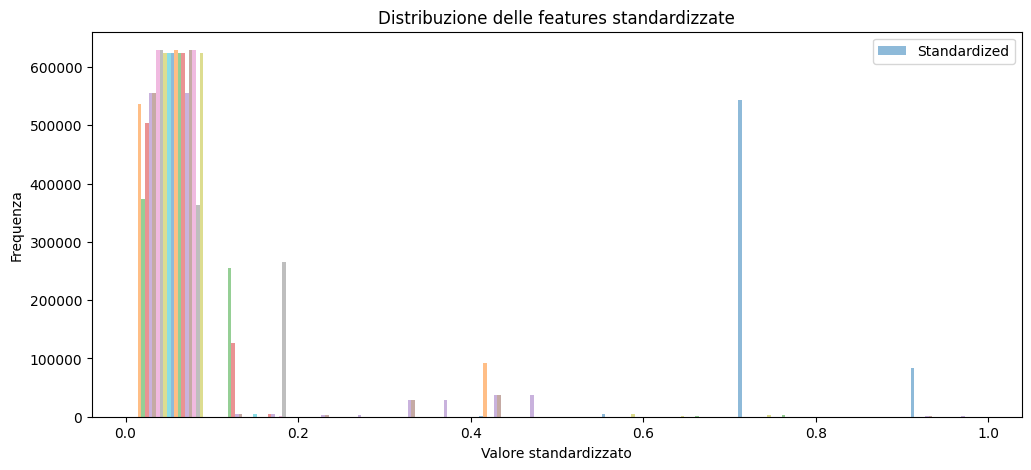

In [62]:
# Grafico dell'istogramma delle features standardizzate
plt.figure(figsize=(12, 5))
plt.hist(X_train, bins=10, alpha=0.5, label='Standardized')
plt.title('Distribuzione delle features standardizzate')
plt.xlabel('Valore standardizzato')
plt.ylabel('Frequenza')
plt.legend()
plt.show()

## TRANSFORMATION PIPELINE

In [63]:
def preprocess_data(df):

    # Converto le colonne in float
    df= df.astype(float)

    # Applico la standardizzazione
    df = min_max_scaler.transform(df)

    return df

In [64]:
# Applico la funzione di preprocessing sia al test set che al validation set
train_set_processed = X_train
val_set_processed = preprocess_data(X_val)
test_set_processed = preprocess_data(X_test)

Definisco la stessa funzione per la k-fold cross validation:

In [65]:
def preprocess_data_cross(df, min_max_scaler):

    # Converto le colonne numeriche in float
    df = df.astype(float)

    # Applico la standardizzazione 
    df= min_max_scaler.transform(df)

    return df

## CHECKING LABEL DISTRIBUTION

Controllo che i target siano ben distribuiti fra tutti i set:

In [66]:
# Calcolo la percentuale di istanze "Benign" e "Malicious" per ogni set
def print_percentage(label_counts, total_instances):
    benign_percentage = (label_counts[0] / total_instances) * 100
    malicious_percentage = (label_counts[1] / total_instances) * 100
    print("Benign: {:.2f}%".format(benign_percentage))
    print("Malicious: {:.2f}%".format(malicious_percentage))
    print("---------------")

# Stampo le percentuali per ogni set
print("Full dataset:\n")
print_percentage(y.value_counts(), len(df))

print("Training set:\n")
print_percentage(y_train.value_counts(), len(X_train))

print("Validation set:\n")
print_percentage(y_val.value_counts(), len(X_val))

print("Test set:\n")
print_percentage(y_test.value_counts(), len(X_test))

Full dataset:

Benign: 42.61%
Malicious: 57.39%
---------------
Training set:

Benign: 42.61%
Malicious: 57.39%
---------------
Validation set:

Benign: 42.59%
Malicious: 57.41%
---------------
Test set:

Benign: 42.62%
Malicious: 57.38%
---------------


# SELECT AND TRAIN A MODEL

Definisco il modello che userò per addestrare la LSTM:

In [67]:
import tensorflow as tf

tf.random.set_seed(42)

def build_model(input_shape):

    # LSTM model
    model = tf.keras.Sequential([
        tf.keras.Input(shape=input_shape),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(64, return_sequences=True),
        tf.keras.layers.LSTM(32, return_sequences=True),
        tf.keras.layers.LSTM(32),
        tf.keras.layers.Dense(1, activation='sigmoid')  # sigmoid for binary classification
    ])

    return model

## 1) TRAIN_TEST_SPLIT

Quando configuro la input_shape nel modello, occorre specificare solo le dimensioni (timesteps, features) perché batch_size viene gestito automaticamente durante l'addestramento. 
Essendo i dati inizialmente in formato 2D (ogni riga rappresenta un campione con 19 feature), la loro forma è (batch_size, 19). Tuttavia, le LSTM richiedono dati di input in formato 3D con la forma (batch_size, timesteps, features), dunque occorre espandere la dimensione dei dati per far sì che ogni campione abbia una dimensione temporale esplicita.

In [68]:
# Aggiungo una dimensione ai dati di input per soddisfare la forma attesa dall'LSTM (batch_size, timesteps, feature per timestep)
X_train_reshaped = np.expand_dims(train_set_processed, axis=1)
X_val_reshaped = np.expand_dims(val_set_processed, axis=1)
X_test_reshaped = np.expand_dims(test_set_processed, axis=1)

Analizzo la dimensione del dataset per decidere il valore da assegnare al parametro _timesteps_:

In [69]:
df.shape

(1048574, 19)

Di seguito provo vari valori per capire quale finestra temporale sia la più adatta al mio modello. Proseguirò in termini di numero di campioni (osservazioni), invece che in termini temporali.

### MODEL 1 (timesteps = 1456)

Scelgo di utilizzare una finestra temporale di 1 minuto, in modo da cogliere eventuali pattern significativi che andrebbero persi con finestre più ampie. Il numero di osservazioni che costituiscono il dataset è di 1048574, lo divido per il numero di minuti totali trascorsi a effettuare le osservazioni (12 ore = 720 min) e ottengo il mio valore di timesteps = 1456 

In [70]:
input_shape_1456 = (1456, len(selected_features)) 

model_1 = build_model(input_shape_1456)

In [71]:
model_1.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [72]:
# Addestro il modello usando i dati preprocessati
history = model_1.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_1.evaluate(X_val_reshaped, y_val)
print(valid_acc * 1e6)

Epoch 1/5


9831/9831 ━━━━━━━━━━━━━━━━━━━━ 29s 3ms/step - accuracy: 0.9718 - loss: 0.0706 - val_accuracy: 0.9954 - val_loss: 0.0265
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9955 - loss: 0.0262 - val_accuracy: 0.9955 - val_loss: 0.0255
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9956 - loss: 0.0250 - val_accuracy: 0.9956 - val_loss: 0.0250
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0246 - val_accuracy: 0.9955 - val_loss: 0.0252
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0243 - val_accuracy: 0.9954 - val_loss: 0.0248
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 815us/step - accuracy: 0.9955 - loss: 0.0255
995565.4144287109


In [73]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_1.evaluate(X_test_reshaped, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 831us/step - accuracy: 0.9957 - loss: 0.0248
Test Accuracy: 99.58%


### MODEL 2 (timesteps = 500)

In [74]:
input_shape_500 = (500,len(selected_features)) 

model_2 = build_model(input_shape_500)

In [75]:
model_2.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [76]:
# Addestro il modello usando i dati preprocessati
history = model_2.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_2.evaluate(X_val_reshaped, y_val)
print(valid_acc * 1e6)

Epoch 1/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9710 - loss: 0.0726 - val_accuracy: 0.9953 - val_loss: 0.0270
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9954 - loss: 0.0268 - val_accuracy: 0.9955 - val_loss: 0.0261
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9955 - loss: 0.0260 - val_accuracy: 0.9954 - val_loss: 0.0261
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9955 - loss: 0.0258 - val_accuracy: 0.9955 - val_loss: 0.0253
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9959 - loss: 0.0232 - val_accuracy: 0.9956 - val_loss: 0.0241
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 819us/step - accuracy: 0.9955 - loss: 0.0246
995579.719543457


In [77]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_2.evaluate(X_test_reshaped, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 800us/step - accuracy: 0.9958 - loss: 0.0236
Test Accuracy: 99.59%


### MODEL 3 (timesteps = 250)

In [78]:
input_shape_250 = (250,len(selected_features)) 

model_3 = build_model(input_shape_250)

In [79]:
model_3.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [80]:
# Addestro il modello usando i dati preprocessati
history = model_3.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_3.evaluate(X_val_reshaped, y_val)
print(valid_acc * 1e6)

Epoch 1/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9717 - loss: 0.0708 - val_accuracy: 0.9942 - val_loss: 0.0276
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9952 - loss: 0.0261 - val_accuracy: 0.9955 - val_loss: 0.0250
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0247 - val_accuracy: 0.9956 - val_loss: 0.0248
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0244 - val_accuracy: 0.9956 - val_loss: 0.0253
Epoch 5/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0244 - val_accuracy: 0.9955 - val_loss: 0.0251
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 793us/step - accuracy: 0.9955 - loss: 0.0253
995598.7930297852


In [81]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_3.evaluate(X_test_reshaped, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 793us/step - accuracy: 0.9957 - loss: 0.0246
Test Accuracy: 99.59%


### MODEL 4 (timesteps = 10.000)

In [82]:
input_shape_10000 = (10000,len(selected_features)) 

model_4 = build_model(input_shape_10000)

In [83]:
model_4.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

early_stopping_cb = tf.keras.callbacks.EarlyStopping(monitor="val_accuracy", patience=3, restore_best_weights=True)

In [84]:
# Addestro il modello usando i dati preprocessati
history = model_4.fit(X_train_reshaped, y_train, epochs=5, batch_size=64, validation_data=(X_val_reshaped, y_val), callbacks=[early_stopping_cb])

# Valuto l'accuratezza del modello sui dati di validazione
valid_loss, valid_acc = model_4.evaluate(X_val_reshaped, y_val)
print(valid_acc * 1e6)

Epoch 1/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 28s 3ms/step - accuracy: 0.9712 - loss: 0.0716 - val_accuracy: 0.9955 - val_loss: 0.0259
Epoch 2/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9956 - loss: 0.0254 - val_accuracy: 0.9953 - val_loss: 0.0267
Epoch 3/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9954 - loss: 0.0260 - val_accuracy: 0.9955 - val_loss: 0.0257
Epoch 4/5
9831/9831 ━━━━━━━━━━━━━━━━━━━━ 25s 3ms/step - accuracy: 0.9957 - loss: 0.0245 - val_accuracy: 0.9955 - val_loss: 0.0252
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 807us/step - accuracy: 0.9954 - loss: 0.0263
995470.0469970703


In [85]:
# Valuto l'accuratezza del modello sui dati del test set
test_loss, test_acc = model_4.evaluate(X_test_reshaped, y_test)
print("Test Accuracy: {:.2f}%".format(test_acc * 100))

6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 819us/step - accuracy: 0.9956 - loss: 0.0253
Test Accuracy: 99.57%


## 2) K-FOLD CROSS-VALIDATION

Per ottenere una migliore valutazione, un'alternativa alla funzione _train-test-split()_ è la feature _k-fold cross validation_ di Scikit-Learn. Questa tecnica consiste nello splittare in maniera randomica il training set in _k_ sottoinsiemi che non si sovrappongono - chiamati _folds_ - ed effettuare addestramento e valutazione _k_ volte, scegliendo a ogni passaggio un fold diverso per la valutazione e i restanti _k-1_ per l'addestramento. Come risultato si ottiene un array contenente i _k_ punteggi di valutazione.

Questo garantisce che ogni parte del dataset venga utilizzata sia per l'addestramento che per la validazione, evitando che si ottenga una valutazione biased come invece può accadere con il _train-test-split()_.

La cross-validation impiega maggiori risorse ma permette di visualizzare delle informazioni aggiuntive: oltre alla stima delle performance del modello, abbiamo infatti a disposizione anche una misura di quanto sia precisa questa stima (ovvero la deviazione standard).

In [86]:
from sklearn.model_selection import KFold

num_folds = 5       # valore di default
input_shape = (1456,19)         # # 1456 osservazioni come timesteps --> prendo il modello migliore

# Configurazione k-fold cross validation
kfold = KFold(n_splits=num_folds, shuffle=True, random_state=42)    #random_state for reproducible output

# Creo una lista che ospiterà i punteggi di ogni fold
scores = []

# Ciclo sui folds
for train_index, val_index in kfold.split(df):

    # Converto i DataFrame in array NumPy
    X_train_cross, X_val_cross = df.iloc[train_index].values, df.iloc[val_index].values
    y_train_cross, y_val_cross = y.iloc[train_index].values, y.iloc[val_index].values

    # Applico le trasformazioni definite nella fase del pre-processamento
    # (stando attenta ad applicarle separatamente per training set e val set per evitare overfitting):

    # Setto il tipo a float (in modo che siano uniformi)
    X_train_cross = X_train_cross.astype(float)

    # Applico la standardizzazione
    min_max_scaler_cross = MinMaxScaler()
    X_train_cross = min_max_scaler_cross.fit_transform(X_train_cross)

    # Applico il pre-processamento anche al set di validazione
    X_val_cross = preprocess_data_cross(X_val_cross, min_max_scaler_cross)

    # Reshape dei dati per la LSTM da 2D a 3D: (campioni, timesteps, features)
    X_train_expanded = np.expand_dims(X_train_cross, axis=1)
    X_val_expanded = np.expand_dims(X_val_cross, axis=1)

    X_train_expanded = np.asarray(X_train_expanded).astype('float32')
    X_val_expanded = np.asarray(X_val_expanded).astype('float32')

    # Costruisco il modello
    model_cross = build_model(input_shape)

    model_cross.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    # Addestro il modello
    model_cross.fit(X_train_expanded, y_train_cross, epochs=5, batch_size=64, validation_data=(X_val_expanded, y_val_cross))

    # Valuto il modello
    scores.append(model_cross.evaluate(X_val_expanded, y_val_cross))

Epoch 1/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9739 - loss: 0.0704 - val_accuracy: 0.9957 - val_loss: 0.0250
Epoch 2/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9952 - loss: 0.0276 - val_accuracy: 0.9944 - val_loss: 0.0279
Epoch 3/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9948 - loss: 0.0260 - val_accuracy: 0.9980 - val_loss: 0.0137
Epoch 4/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9977 - loss: 0.0148 - val_accuracy: 0.9980 - val_loss: 0.0138
Epoch 5/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9978 - loss: 0.0143 - val_accuracy: 0.9980 - val_loss: 0.0135
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 815us/step - accuracy: 0.9984 - loss: 0.0107
Epoch 1/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 36s 2ms/step - accuracy: 0.9744 - loss: 0.0696 - val_accuracy: 0.9955 - val_loss: 0.0256
Epoch 2/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9949 - loss: 0.0291 - val_accuracy: 0.9943 - val_loss: 0.03

In [87]:
# Calcolo la media e la deviazione standard dei punteggi ottenuti
scores = np.array(scores)
mean_score = scores.mean(axis=0)
std_score = scores.std(axis=0)
print(f"Mean score: {mean_score}")
print(f"Standard deviation score: {std_score}")

Mean score: [0.01462995 0.99756908]
Standard deviation score: [0.00232333 0.0004972 ]


Il risultato ottenuto sembra ottimo:
- 99,7 % di accuratezza con l'1,5% di perdita
- deviazione standard trascurabile, ovvero le prestazioni del modello sono stabili tra i vari folds

### Stratified k-fold cross validation

Proviamo ora a vedere se le prestazioni del modello variano usando una variante, ovvero la _stratified k-fold cross validation_, utilizzata nei casi di distribuzioni sbilanciate dei target. L'idea è quella di far sì che la distribuzione delle etichette di ogni fold sia pressochè la stessa della distribuzione originale del dataset, ovvero ogni fold deve essere rappresentativo del dataset intero. Nella k-fold cross validation invece, la divisione dei dati è casuale. 

In [88]:
from sklearn.model_selection import StratifiedKFold

num_folds = 5
input_shape = (1456, len(selected_features)) 

# Configurazione stratified k-fold cross validation
stratkfold = StratifiedKFold(n_splits=num_folds, shuffle=True, random_state=42)    #random_state for reproducible output

# Creo una lista che ospiterà i punteggi di ogni fold
scores = []

# Ciclo sui folds
for train_index, val_index in stratkfold.split(df, y):

    
    # Converto i DataFrame in array NumPy
    X_train_str_cross, X_val_str_cross = df.iloc[train_index].values, df.iloc[val_index].values
    y_train_str_cross, y_val_str_cross = y.iloc[train_index].values, y.iloc[val_index].values

    # Applico le trasformazioni definite nella fase del pre-processamento
    # (stando attenta ad applicarle separatamente per training set e val set per evitare overfitting):

    # Setto il tipo a float (in modo che siano uniformi)
    X_train_str_cross = X_train_str_cross.astype(float)

    # Applico la standardizzazione
    min_max_scaler_str_cross = MinMaxScaler()
    X_train_str_cross = min_max_scaler_str_cross.fit_transform(X_train_str_cross)

    # Applico il pre-processamento anche al set di validazione
    X_val_str_cross = preprocess_data_cross(X_val_str_cross, min_max_scaler_str_cross)

    # Reshape dei dati per la LSTM da 2D a 3D: (campioni, timesteps, features)
    X_train_str_expanded = np.expand_dims(X_train_str_cross, axis=1)
    X_val_str_expanded = np.expand_dims(X_val_str_cross, axis=1)

    X_train_str_expanded = np.asarray(X_train_str_expanded).astype('float32')
    X_val_str_expanded = np.asarray(X_val_str_expanded).astype('float32')

    # Costruisco il modello
    model_str_cross = build_model(input_shape)

    model_str_cross.compile(loss='binary_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])
    
    # Addestro il modello
    model_str_cross.fit(X_train_str_expanded, y_train_str_cross, epochs=5, batch_size=64, validation_data=(X_val_str_expanded, y_val_str_cross))

    # Valuto il modello
    scores.append(model_str_cross.evaluate(X_val_str_expanded, y_val_str_cross))

Epoch 1/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 35s 2ms/step - accuracy: 0.9749 - loss: 0.0666 - val_accuracy: 0.9956 - val_loss: 0.0253
Epoch 2/5
10828/13108 ━━━━━━━━━━━━━━━━━━━━ 5s 2ms/step - accuracy: 0.9953 - loss: 0.0268

13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9953 - loss: 0.0271 - val_accuracy: 0.9955 - val_loss: 0.0261
Epoch 3/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9954 - loss: 0.0256 - val_accuracy: 0.9979 - val_loss: 0.0158
Epoch 4/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9977 - loss: 0.0154 - val_accuracy: 0.9979 - val_loss: 0.0143
Epoch 5/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9975 - loss: 0.0152 - val_accuracy: 0.9979 - val_loss: 0.0141
6554/6554 ━━━━━━━━━━━━━━━━━━━━ 5s 823us/step - accuracy: 0.9982 - loss: 0.0119
Epoch 1/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 37s 3ms/step - accuracy: 0.9748 - loss: 0.0693 - val_accuracy: 0.9946 - val_loss: 0.0342
Epoch 2/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9949 - loss: 0.0291 - val_accuracy: 0.9955 - val_loss: 0.0193
Epoch 3/5
13108/13108 ━━━━━━━━━━━━━━━━━━━━ 32s 2ms/step - accuracy: 0.9964 - loss: 0.0194 - val_accuracy: 0.9977 - val_loss: 0.0158
Epoch 4

In [89]:
# Calcolo la media e la deviazione standard dei punteggi ottenuti
scores = np.array(scores)
mean_score = scores.mean(axis=0)
std_score = scores.std(axis=0)
print(f"Mean score: {mean_score}")
print(f"Standard deviation score: {std_score}")

Mean score: [0.01637542 0.99738789]
Standard deviation score: [0.00524759 0.00104026]


I risultati non mostrano variazioni significative.

## SAVE THE MODEL

Salvo il modello che ha ottenuto le prestazioni migliori:

In [91]:
# Save the entire model as a `.keras` zip archive
model_1.save('LSTM_binary_cross.keras')

In [92]:
# Reload the Keras model from the .keras zip archive
saved_model = tf.keras.models.load_model('LSTM_binary_cross.keras')

# Show the model architecture
saved_model.summary()

Model: "sequential_13"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm_52 (LSTM)                  │ (None, 1456, 64)       │        21,504 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_53 (LSTM)                  │ (None, 1456, 64)       │        33,024 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_54 (LSTM)                  │ (None, 1456, 32)       │        12,416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ lstm_55 (LSTM)                  │ (None, 32)             │         8,320 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │            33 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 225,893 (882.40 KB)

 Trainable params: 75,297 (294.13 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 150,596 (588.27 KB)